In [37]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand, normal, uniform
import corner

In [38]:
def slicer(g, dim, x0, xargs, N=1000, w=0.5, m=10):
    """MCMC slice sampler: 
            g -- function or distribution
            dim -- number of dimensions
            x0 -- initial guess (vector of parameters)
            xargs -- extra arguments for g (often data-related)
            N -- number of values in Markov chain to return 
            w -- step-out width for slice sampling
            m -- maximum for step-out scaling
        Returns: (xs, likelies)
            xs[N, dim] -- resulting Markov chain (includes initial guess as 0th)
            likelies[N] -- vector of log-likelihoods of chain
            
        See: Neal, "Slice Sampling," The Annals of Statistics 2003, vol. 31 (705-767). This is available online
        --D. Craig converted from Julia mslicer, 2019 Jan 15.
        """
    # based on Julia mslicer, version in mslicer-keeplikes.ipynb
    xs = np.zeros((N, dim), dtype=np.float64)    # array (Markov chain) that will be returned
    xs[0,:] = x0             #initial guess into the chain
    x1 = np.zeros(dim)
    L = np.zeros(dim)
    R = np.zeros(dim)
    likelies = np.zeros(N)     # record log likelihoods
    likelies[0] = g(x0,xargs)  # get log-like of initial guess; avoid fencepost error
    way = np.zeros(dim)  # which axis to go along in space
    i = 1    # assumed start values for chain are recorded at xs[0,:]; this will be index of first generated point 
    while i < N:
        for d in range(dim):     # go one step in each dimensional direction.
            way = 0.0 * way #clear it
            way[d] = 1.0 #set nonzero in direction we go for slicing on this step
            y0 = g(x0,xargs)  #height of distribution at x0
            y = y0 + np.log(rand()) # height for slice (using log scaled distribution)
            #start stepping out
            U = rand()   # between 0 and 1
            L = x0 - (w * way * U)
            R = L + w * way
            V = rand()
            J = np.floor(m*V)
            K = (m - 1) - J
            while J > 0 and y < g(L,xargs):
                L = L - w * way
                J = J - 1
            while K > 0 and y < g(R,xargs):
                R = R + w * way
                K = K - 1
            #now should be stepped out beyond distribution at slice level
            # work back in if no value found:
            Lbar, Rbar = L, R
            while True: 
                U = rand()
                x1 = Lbar + U * (Rbar - Lbar)  # vector subtraction should be correct dir
                if y < g(x1,xargs):
                    break # exit while loop
                if x1[d] < x0[d]:
                        Lbar = x1
                else: 
                        Rbar = x1
            xs[i,:] = x1 # found an acceptable point, record in chain (a row)
            likelies[i] = y0 # record log-likelhood
            x0 = x1 # set initial to new point for next round.
            i += 1
            if i >= N:
                break # catch case where we reach N in the middle of set of dimensions
    return xs, likelies 

In [39]:
# Make a cubic
def cubemodel(x,A0,A1,A2,A3):
    y = A0 + x*(A1 + x*(A2 + x*A3))
    return y

In [35]:
x = np.linspace(-10,10)
yc = cubemodel(x,-40,-18,1.4,0.3)

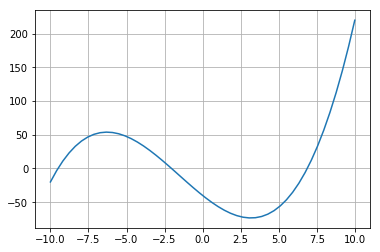

In [43]:
plt.plot(x, yc)
plt.grid()

In [103]:
xd = np.empty(20)
for i in range(20):
    xd[i] = i-10.0 + normal(scale=2)  #even with jitter

In [104]:
N = len(xd)
# we want x, y, s
data = np.empty((N,3),float)
for v in range(N):
    s = uniform(20, 80)  #std dev for each point
    y = cubemodel(xd[v],-40,-18,1.4,0.3) + normal(scale=s)
    data[v,0] = xd[v]
    data[v,1] = y
    data[v,2] = s

    

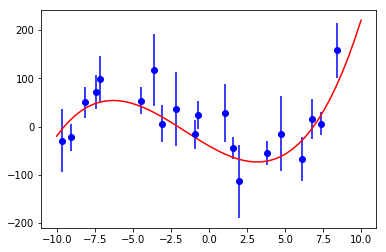

In [105]:
plt.errorbar(data[:,0], data[:,1], yerr = data[:,2], fmt='bo')
plt.plot(x, yc, color="red")